Time Series Analysis 
Box Jenkins and ARIMA 
Cristel Irwin

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pandas import datetime
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

C:\Users\s_cri\AppData\Local\Temp/ipykernel_248/3464462392.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df = pd.read_csv('robberies.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [3]:
df.head()

Month
1966-01-01    41
1966-02-01    39
1966-03-01    50
1966-04-01    40
1966-05-01    43
Name: Robberies, dtype: int64

# 1. Perform a complete Box-Jenkins analysis to arrive at what you believe to be the optimum ARIMA(p,d,q) model

Slides 12 & 13

a. Plot the series

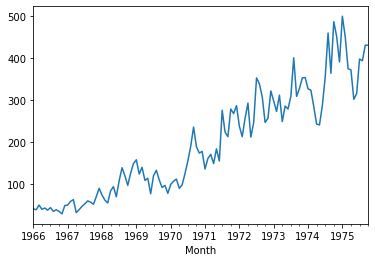

In [4]:
df.plot()
pyplot.show()

b. Perform a Dickey-Fuller test on the series. Is the series stationary?

In [5]:
#Dickey-Fuller

X = df.values
X = X.astype('float32')

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('\np-value: %f' % result[1])
print('\nCritical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.001102

p-value: 0.994278

Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


In [6]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

(0.011921123168961295, False)

The data is non-stationary.

c. Plot the ACF & PACF and observe the trends.

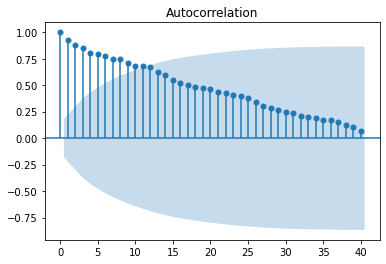

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df, lags=40)
pyplot.show()

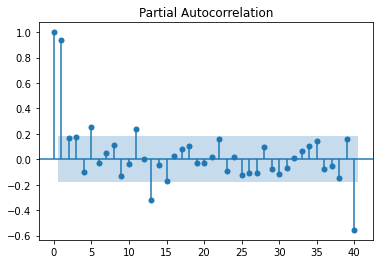

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df, lags=40)
pyplot.show()

#Trends:
  
  I believe this data shows an exponential decay. The ACF decays geometrically. The PACF shows a strong correlation at lag = 1 and negative correlation at lag = -40. 

d. Perform differencing on the series.

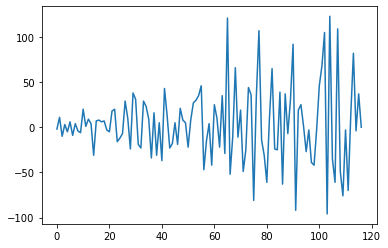

In [9]:
def parser(x):
    return datetime.strptime('365'+x, '%Y-%m')

X = df.values

diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
pyplot.plot(diff)
pyplot.show()

e. Is the differenced series stationary?


Yes, it is stationary

f. Plot the ACF & PACF of the differenced data and select the p & q orders.

In [10]:
diff = pd.DataFrame(diff)

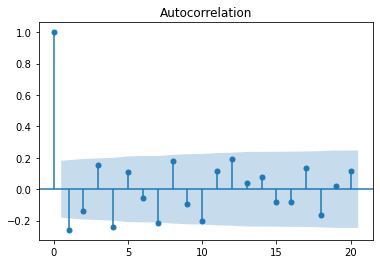

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(diff, lags=20)
pyplot.show()

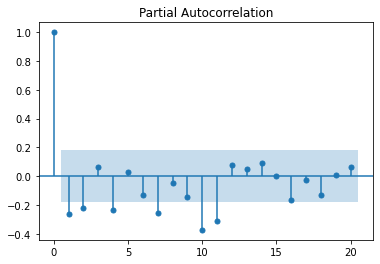

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(diff, lags=20)
pyplot.show()

Select the p & q orders

ARMA (2, 1)

g. Run an ARIMA analysis with the original series and the (p,d,q) you've deduced from above.


In [13]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df, order= (2, 1, 1))  #(p,d,q) 
model_fit = model.fit(disp = 0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Robberies   No. Observations:                  117
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -592.107
Method:                       css-mle   S.D. of innovations             38.118
Date:                Sat, 23 Apr 2022   AIC                           1194.213
Time:                        15:06:12   BIC                           1208.024
Sample:                    02-01-1966   HQIC                          1199.820
                         - 10-01-1975                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.2980      2.539      1.299      0.194      -1.679       8.275
ar.L1.D.Robberies    -0.8811      0.168     -5.235      0.000      -1.211      -0.551
ar.L2.D.Robberies    -0.

h. Plot the residuals.

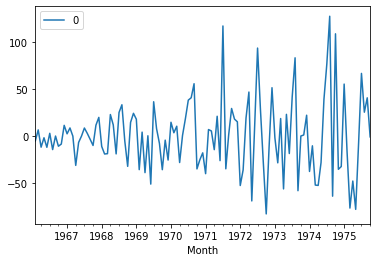

In [14]:
residuals = pd.DataFrame(model_fit.resid)

residuals.plot()
pyplot.show()

i. Plot the residual distribution (kind='kde').

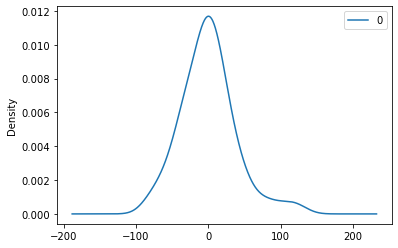

In [15]:
residuals.plot(kind="kde")
pyplot.show()

j. Print the residuals summary.

In [16]:
print(residuals.describe())

                0
count  117.000000
mean     0.002927
std     38.282841
min    -83.077259
25%    -25.757255
50%     -0.239510
75%     18.435410
max    127.310503


k. Plot the ACF & PACF and observe for residual correlations.

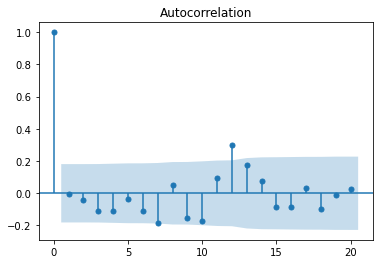

In [17]:
plot_acf(residuals, lags = 20)
pyplot.show()

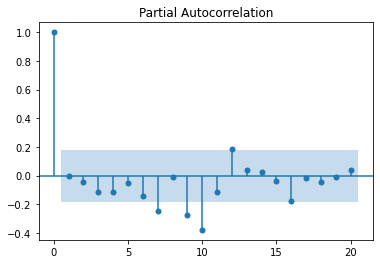

In [18]:
plot_pacf(residuals, lags = 20)
pyplot.show()

l.Compare the model results series to the actuals:
    
i Convert the residuals to the series estimated by ARIMA (hint: resids = y - yhat).

ii Add back the differencing to compare with the original series.

iii Plot the actual and modeled results on the same graph.

In [99]:
resids = pd.DataFrame(model_fit.resid)

d = 1

dhat = list()

for t in range(0, len(resids)):
    value = d[t] - resids[t]
    dhat.append(value)

shat = list()
shat.append(s[0])

for t in range(0, len(dhat)):
    value = dhat[t] + s[t]
    shat.append(value)
    
print("Compare model red to original data blue")
pyplot.plot(y, color = 'blue')
pyplot.plot(shat, color = 'red')
pyplot.show()

TypeError: 'int' object is not subscriptable

## 2 Create a AIC grid search and run 'robberies.csv' through it to find the optimum p,d,q order

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy
# create a differenced series

def difference(df, interval=1):
    diff = list()
    for i in range(interval, len(df)):
        value = df[i] - df[i - interval]
        diff.append(value)
    return numpy.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
# difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = series.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except: 
                    continue
        print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset
series =  df
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) RMSE=57.068
ARIMA(0, 0, 1) RMSE=56.916
ARIMA(0, 0, 2) RMSE=58.717
ARIMA(0, 0, 3) RMSE=54.910
ARIMA(0, 0, 4) RMSE=56.321
ARIMA(0, 0, 5) RMSE=54.460
ARIMA(0, 0, 6) RMSE=58.473
ARIMA(0, 1, 0) RMSE=64.958
ARIMA(0, 1, 1) RMSE=55.626
ARIMA(0, 1, 2) RMSE=56.735
ARIMA(0, 1, 3) RMSE=57.512
ARIMA(0, 1, 4) RMSE=56.762
ARIMA(0, 1, 5) RMSE=59.327
ARIMA(0, 1, 6) RMSE=57.088
ARIMA(0, 2, 0) RMSE=110.491
ARIMA(0, 2, 1) RMSE=65.396
ARIMA(0, 2, 2) RMSE=56.256
ARIMA(0, 2, 3) RMSE=57.648
ARIMA(0, 2, 4) RMSE=58.038
ARIMA(0, 2, 5) RMSE=58.555
ARIMA(0, 2, 6) RMSE=58.566
Best ARIMA(0, 0, 5) RMSE=54.460
ARIMA(1, 0, 0) RMSE=55.955
ARIMA(1, 0, 1) RMSE=54.032
ARIMA(1, 0, 2) RMSE=54.636
ARIMA(1, 0, 3) RMSE=54.264
ARIMA(1, 0, 4) RMSE=55.104
ARIMA(1, 0, 5) RMSE=56.121
ARIMA(1, 0, 6) RMSE=58.758
ARIMA(1, 1, 0) RMSE=58.225
ARIMA(1, 1, 1) RMSE=57.107
ARIMA(1, 1, 2) RMSE=55.728
ARIMA(1, 1, 3) RMSE=56.100
ARIMA(1, 1, 4) RMSE=56.074
ARIMA(1, 1, 5) RMSE=57.791
ARIMA(1, 1, 6) RMSE=58.549
ARIMA(1, 2, 0) RMSE=86

What is the optimum p,d,q order?

Prof, which (p,d,q) values from the output should I use?

Best ARIMA(0, 0, 5) RMSE=54.460

## 3 Compare the results of your orginal (p,d,q) estimate to the results from the grid search (p,d,q).

Compare the residuals summaries.
Compare the graphs generated by the script made in 1.l above.

*** I had problems installing statsmodel version you recommended and running your code for the AIC grid. So I used te code in the book.  But I am not sure which (p,d,q) values to compare.***

## 4 Forecast 'robberies.csv' based on an ARIMA(2,1,1) model: Split the series into 75% train, 25% test

a. Perform a dynamic forecast for all points in 'test'
Plot the forecasted data and the prediction intervals on top of the actual data

In [87]:
X = df.values
X = X.astype('float64')
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

In [88]:
p = 2
d = 0
q = 1

In [89]:
model = ARIMA(history, order =(p,d,q))
model_fit = model.fit(disp=0)
predictions = model_fit.forecast(steps = len(test))[0]
limits = pd.DataFrame(model_fit.forecast(steps=len(test))[2])
lowerlimit = limits[0]
upperlimit = limits[1]
predictionint = upperlimit - lowerlimit

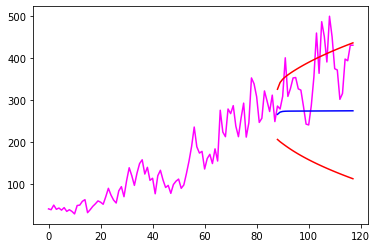


Full prediction interval: 


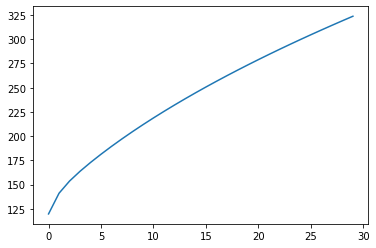

In [90]:
pyplot.plot(X, color='magenta')
pyplot.plot([None for i in train] + [x for x in predictions], color ='blue')
pyplot.plot([None for i in train] + [x for x in upperlimit], color ='red')
pyplot.plot([None for i in train] + [x for x in lowerlimit], color ='red')
pyplot.show()

print()
print("Full prediction interval: ")
pyplot.plot(predictionint)
pyplot.show()

b. Perform a rolling forecast for all points in 'test'
Plot the forecasted data and the prediction intervals on top of the actual data

predicted=274.218432, expected=286.000000
predicted=297.693001, expected=279.000000
predicted=274.286969, expected=309.000000
predicted=309.552833, expected=401.000000
predicted=350.553169, expected=309.000000
predicted=314.749825, expected=328.000000
predicted=345.142890, expected=353.000000
predicted=345.174185, expected=354.000000
predicted=375.791991, expected=327.000000
predicted=325.131135, expected=324.000000
predicted=341.822378, expected=285.000000
predicted=313.886940, expected=243.000000
predicted=279.930599, expected=241.000000
predicted=259.122806, expected=287.000000
predicted=284.419379, expected=355.000000
predicted=323.258410, expected=460.000000
predicted=411.144060, expected=364.000000
predicted=337.762319, expected=487.000000
predicted=464.070087, expected=452.000000
predicted=444.372345, expected=391.000000
predicted=438.590410, expected=500.000000
predicted=455.701959, expected=451.000000
predicted=464.778498, expected=375.000000
predicted=431.402661, expected=372

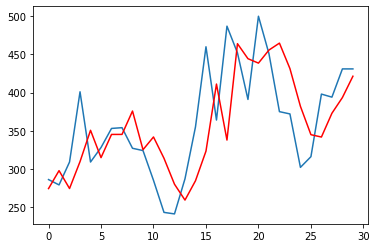

In [98]:
X = df.values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order = (5,1,0))
    model_fit = model.fit(dispt=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()